In [1]:
#To hide warnings export PYTHONWARNINGS="ignore"
#Imports{

import os
from os.path import dirname
from os.path import join
os.environ['KERAS_BACKEND'] = 'theano'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Cha


import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import cPickle as pickle
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.misc import imread
from scipy.misc import imresize
from scipy.io import loadmat
from scipy.interpolate import spline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.cluster import MiniBatchKMeans

from matplotlib.ticker import MaxNLocator
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, MaxPooling2D, Input, ZeroPadding2D,merge,Lambda
from keras.layers.convolutional import Convolution2D
from keras.models import Model
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.optimizers import SGD
from keras import backend as K
from keras.engine import Layer
from keras.layers.core import Lambda
from keras.utils.vis_utils import plot_model
from keras.layers.core import  Lambda
from keras.regularizers import l2
import hdbscan
#}

Using Theano backend.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
#Code snippet needed to read activation values from each layer of the pre-trained artificial neural networks
def get_activations(model, layer, X_batch):
    #keras.backend.function(inputs, outputs, updates=None)
    get_activations = K.function([model.layers[0].input, K.learning_phase()], [model.layers[layer].output,])
    #The learning phase flag is a bool tensor (0 = test, 1 = train)
    activations = get_activations([X_batch,0])
    return activations

In [3]:
#Function to pre-process the input image to ensure uniform size and color
def preprocess_image_batch(image_paths, img_size=None, crop_size=None, color_mode='rgb', out=None):
    """
    Consistent preprocessing of images batches
    :param image_paths: iterable: images to process
    :param crop_size: tuple: crop images if specified
    :param img_size: tuple: resize images if specified
    :param color_mode: Use rgb or change to bgr mode based on type of model you want to use
    :param out: append output to this iterable if specified
    """
    img_list = []

    for im_path in image_paths:
        img = imread(im_path, mode='RGB')
        #print im_path
        #print img.shape
        if img_size:
            img = imresize(img, img_size)

        img = img.astype('float32')
        # We normalize the colors (in RGB space) with the empirical means on the training set
        img[:, :, 0] -= 123.68
        img[:, :, 1] -= 116.779
        img[:, :, 2] -= 103.939
        # We permute the colors to get them in the BGR order
        if color_mode == 'bgr':
            img[:, :, [0, 1, 2]] = img[:, :, [2, 1, 0]]
        img = img.transpose((2, 0, 1))

        if crop_size:
            img = img[:, (img_size[0] - crop_size[0]) // 2:(img_size[0] + crop_size[0]) // 2
            , (img_size[1] - crop_size[1]) // 2:(img_size[1] + crop_size[1]) // 2]

        img_list.append(img)

    try:
        img_batch = np.stack(img_list, axis=0)
    except:
        print im_path
        raise ValueError('when img_size and crop_size are None, images'
                ' in image_paths must have the same shapes.')

    if out is not None and hasattr(out, 'append'):
        out.append(img_batch)
    else:
        return img_batch

In [4]:
#Helper function to normalization across channels
K.set_image_dim_ordering('th')
def crosschannelnormalization(alpha=1e-4, k=2, beta=0.75, n=5, **kwargs):
    """
    This is the function used for cross channel normalization in the original
    Alexnet
    """
    def f(X):
        if K.image_dim_ordering()=='tf':
            b, r, c, ch = X.get_shape()
        else:
            b, ch, r, c = X.shape

        half = n // 2
        square = K.square(X)
        scale = k
        if K.image_dim_ordering() == 'th':
            extra_channels = K.spatial_2d_padding(K.permute_dimensions(square, (0, 2, 3, 1)), ((0,0),(half,half)))
            extra_channels = K.permute_dimensions(extra_channels, (0, 3, 1, 2))
            for i in range(n):
                scale += alpha * extra_channels[:, i:i+ch, :, :]
        if K.image_dim_ordering() == 'tf':
            extra_channels = K.spatial_2d_padding(K.permute_dimensions(square, (0, 3, 1, 2)), (half, 0))
            extra_channels = K.permute_dimensions(extra_channels, (0, 2, 3, 1))
            for i in range(n):
                scale += alpha * extra_channels[:, :, :, i:i+int(ch)]
        scale = scale ** beta
        return X / scale


    return Lambda(f, output_shape=lambda input_shape: input_shape, **kwargs)

In [5]:
#Helper Function to split tensor
def splittensor(axis=1, ratio_split=1, id_split=0, **kwargs):
    def f(X):
        div = K.shape(X)[axis] // ratio_split

        if axis == 0:
            output = X[id_split*div:(id_split+1)*div, :, :, :]
        elif axis == 1:
            output = X[:, id_split*div:(id_split+1)*div, :, :]
        elif axis == 2:
            output = X[:, :, id_split*div:(id_split+1)*div, :]
        elif axis == 3:
            output = X[:, :, :, id_split*div:(id_split+1)*div]
        else:
            raise ValueError("This axis is not possible")
        return output

    def g(input_shape):
        output_shape = list(input_shape)
        output_shape[axis] = output_shape[axis] // ratio_split
        return tuple(output_shape)


    return Lambda(f, output_shape=lambda input_shape: g(input_shape), **kwargs)

In [6]:
#Alexnet layer architecture class
def AlexNet(img_shape=(3, 227, 227), n_classes=1000, l2_reg=0.,weights_path=None, lambda_mask=None):

    dim_ordering = K.image_dim_ordering()
    print dim_ordering
    if dim_ordering == 'th':
        batch_index = 0
        channel_index = 1
        row_index = 2
        col_index = 3
    if dim_ordering == 'tf':
        batch_index = 0
        channel_index = 3
        row_index = 1
        col_index = 2
        
    
    inputs = Input(img_shape)

    conv_1 = Convolution2D(96, 11, 11, subsample=(4, 4), activation='relu',
                           name='conv_1', W_regularizer=l2(l2_reg))(inputs)

    if lambda_mask is not None:
        conv_1_mask  = np.reshape(lambda_mask[0:290400], (96,55,55))
    else:
        conv_1_mask = np.ones(shape=((96, 55, 55)))
    
    conv_1_mask  = K.variable(conv_1_mask)
    conv_1_lambda = Lambda(lambda x: x * conv_1_mask)(conv_1)

    conv_2 = MaxPooling2D((3, 3), strides=(2, 2))(conv_1_lambda)
    conv_2 = crosschannelnormalization(name="convpool_1")(conv_2)
    conv_2 = ZeroPadding2D((2, 2))(conv_2)
    conv_2 = merge([
        Convolution2D(128, 5, 5, activation="relu", name='conv_2_'+str(i+1),
                      W_regularizer=l2(l2_reg))(
            splittensor(axis=channel_index, ratio_split=2, id_split=i)(conv_2)
        ) for i in range(2)], mode='concat', concat_axis=channel_index, name="conv_2")

    if lambda_mask is not None:
        conv_2_mask  = np.reshape(lambda_mask[290400:477024],(256, 27, 27) )
    else:
        conv_2_mask = np.ones(shape=((256, 27, 27)))
        
    conv_2_mask = K.variable(conv_2_mask)
    conv_2_lambda = Lambda(lambda x: x * conv_2_mask)(conv_2)

    conv_3 = MaxPooling2D((3, 3), strides=(2, 2))(conv_2_lambda)
    conv_3 = crosschannelnormalization()(conv_3)
    conv_3 = ZeroPadding2D((1, 1))(conv_3)
    conv_3 = Convolution2D(384, 3, 3, activation='relu', name='conv_3',
                           W_regularizer=l2(l2_reg))(conv_3)

    if lambda_mask is not None:
        conv_3_mask  = np.reshape(lambda_mask[477024:541920],(384, 13, 13))
    else:
        conv_3_mask = np.ones(shape=((384, 13, 13)))
    
    conv_3_mask = K.variable(conv_3_mask)
    conv_3_lambda = Lambda(lambda x: x * conv_3_mask)(conv_3)

    conv_4 = ZeroPadding2D((1, 1))(conv_3_lambda)
    conv_4 = merge([
        Convolution2D(192, 3, 3, activation="relu", name='conv_4_'+str(i+1),
                      W_regularizer=l2(l2_reg))(
            splittensor(axis=channel_index, ratio_split=2, id_split=i)(conv_4)
        ) for i in range(2)], mode='concat', concat_axis=channel_index, name="conv_4")

    if lambda_mask is not None:
        conv_4_mask  = np.reshape(lambda_mask[541920:606816],(384, 13, 13))
    else:
        conv_4_mask = np.ones(shape=((384, 13, 13)))
        
    conv_4_mask = K.variable(conv_4_mask)
    conv_4_lambda = Lambda(lambda x: x * conv_4_mask)(conv_4)

    conv_5 = ZeroPadding2D((1, 1))(conv_4_lambda)
    conv_5 = merge([
        Convolution2D(128, 3, 3, activation="relu", name='conv_5_'+str(i+1),
                      W_regularizer=l2(l2_reg))(
            splittensor(axis=channel_index, ratio_split=2, id_split=i)(conv_5)
        ) for i in range(2)], mode='concat', concat_axis=channel_index, name="conv_5")

    if lambda_mask is not None:
        conv_5_mask  = np.reshape(lambda_mask[606816:650080],(256, 13, 13))
    else:
        conv_5_mask = np.ones(shape=((256, 13, 13)))
    
    conv_5_mask = K.variable(conv_5_mask)
    conv_5_lambda = Lambda(lambda x: x * conv_5_mask)(conv_5)

    dense_1 = MaxPooling2D((3, 3), strides=(2, 2), name="convpool_5")(conv_5_lambda)

    dense_1 = Flatten(name="flatten")(dense_1)
    dense_1 = Dense(4096, activation='relu', name='dense_1',
                    W_regularizer=l2(l2_reg))(dense_1)

    if lambda_mask is not None:
        dense_1_mask  = np.reshape(lambda_mask[650080:654176],(4096,))
    else:
        dense_1_mask = np.ones(shape=((4096,)))
    
    
    dense_1_mask = K.variable(dense_1_mask)
    dense_1_lambda = Lambda(lambda x: x * dense_1_mask)(dense_1)

    dense_2 = Dropout(0.5)(dense_1_lambda)
    dense_2 = Dense(4096, activation='relu', name='dense_2',
                    W_regularizer=l2(l2_reg))(dense_2)

    if lambda_mask is not None:
        dense_2_mask  = np.reshape(lambda_mask[654176:658272],(4096,))
    else:
        dense_2_mask = np.ones(shape=((4096,)))
    
    dense_2_mask = K.variable(dense_2_mask)
    dense_2_lambda = Lambda(lambda x: x * dense_2_mask)(dense_2)

    dense_3 = Dropout(0.5)(dense_2_lambda)
    if n_classes == 1000:
        dense_3 = Dense(n_classes, name='dense_3',
                        W_regularizer=l2(l2_reg))(dense_3)

    else:
        # We change the name so when loading the weights_file from a
        # Imagenet pretrained model does not crash
        dense_3 = Dense(n_classes, name='dense_3_new',
                        W_regularizer=l2(l2_reg))(dense_3)

    prediction = Activation("softmax", name="softmax")(dense_3)

    model = Model(input=inputs, output=prediction)
    if weights_path:
        model.load_weights(weights_path)

    return model

In [7]:
#Load the details of all the 1000 classes and the function to conver the synset id to words{
meta_clsloc_file = '../../data/meta_clsloc.mat'
synsets = loadmat(meta_clsloc_file)['synsets'][0]
synsets_imagenet_sorted = sorted([(int(s[0]), str(s[1][0])) for s in synsets[:1000]],key=lambda v: v[1])
corr = {}
for j in range(1000):
    corr[synsets_imagenet_sorted[j][0]] = j

corr_inv = {}
for j in range(1, 1001):
    corr_inv[corr[j]] = j

def id_to_words(id_):
    return synsets[corr_inv[id_] - 1][2][0]

def pprint_output(out, n_max_synsets=10):
    wids = []
    best_ids = out.argsort()[::-1][:10]
    for u in best_ids:
        wids.append(str(synsets[corr_inv[u] - 1][1][0]))
    #print('%.2f' % round(100 * out[u], 2) + ' : ' + id_to_words(u)+' '+ str(synsets[corr_inv[u] - 1][1][0]))
    return wids


In [8]:
#Code snippet to load the ground truth labels to measure the performance{
truth = {}
with open('../../data/ILSVRC2014_clsloc_validation_ground_truth.txt') as f:
    line_num = 1
    for line in f.readlines():
        ind_ = int(line)
        temp  = None
        for i in synsets_imagenet_sorted:
            if i[0] == ind_:
                temp = i
        #print ind_,temp
        if temp != None:
            truth[line_num] = temp
        else:
            print '##########', ind_
            pass
        line_num += 1
#}

In [9]:
#Function to predict the top 5 accuracy
def top5accuracy(true, predicted):
    assert len(true) == len(predicted)
    result = []
    flag  = 0
    for i in range(len(true)):
        flag  = 0
        temp = true[i]
        for j in predicted[i]:
            if j == temp:
                flag = 1
                break
        if flag == 1:
            result.append(1)
        else:
            result.append(0)
    counter = 0.
    for i in result:
        if i == 1:
            counter += 1.
    error = 1.0 - counter/float(len(result))
    #print len(np.where(np.asarray(result) == 1)[0])
    return len(np.where(np.asarray(result) == 1)[0]), error


In [ ]:
%%time
#Test Cell 1
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

data_path = '../../data/pkl/'
classes = ['animate','inanimate']
fold = 1

with open(data_path+classes[0]+'_train.pkl') as f:
        X_fold = pickle.load(f)
with open(data_path+classes[1]+'_train.pkl') as f:
        y_fold = pickle.load(f)
    
X = np.column_stack((X_fold,y_fold))
X = np.float32(X)

kmeans = MiniBatchKMeans(n_clusters=65827,
                         batch_size=6,
                         max_iter=10).fit(X)
kmeans.cluster_centers_
pred_kmeans = kmeans.predict(X)
X_new = kmeans.cluster_centers_

with open('../../data/pkl/kmeans_first_train.pickle', 'wb') as handle:
    pickle.dump([X_new,pred_kmeans,kmeans], handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
with open('../../data/pkl/kmeans_first_train.pickle',"rb") as f:
    X_new,pred_kmeans,kmeans = pickle.load(f)

In [ ]:
X_new.dtype

In [ ]:
%%time
#Test Cell 2
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
result= {}   

j=14
clf_result = {}
clf_result[j] = {}
#clf = KMeans(n_clusters=j)
#clf = SpectralClustering(n_clusters=j,assign_labels="discretize")
clf =  AgglomerativeClustering(n_clusters=j, linkage='ward')
#clf = Birch(branching_factor=50, n_clusters=j, threshold=0.5,compute_labels=True)
#clf = GaussianMixture(n_components=j, covariance_type='full')
y_pred = clf.fit_predict(X_new)


for label in set(clf.labels_):
    print('Cluster: ',j,'Label: ', label)

    #Lesioning and measuring performance
    pred = y_pred
    loc = np.where(pred==label)
    loc_temp = kmeans.predict(X_new[loc[0]])
    loc_new =[]
    for entry in set(loc_temp):
        temp = np.where(pred_kmeans==entry)[0]
        loc_new.extend(temp)
 
    lambda_mask = np.ones(shape=((658272,)))
    lambda_mask[loc_new] = 0.

    #plt.scatter(X[:,0],X[:,1], c=y_pred) 

    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    model = AlexNet(weights_path="../../data/weights/alexnet_weights.h5",lambda_mask=lambda_mask)
    model.compile(optimizer=sgd, loss='mse')

    flag = 0
    dprime = 0.
    for p in classes:
        im_valid_test = []
        image_list_valid = '../../data/pkl/'+p+'_image_list_valid_fold_'+str(fold)+'.txt'
        with open(image_list_valid,'rb') as f:
            for line in f.readlines():
                im_valid_test.append(line.strip('\n'))
        im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(227,227), color_mode="rgb")
        out = model.predict(im_temp,batch_size=64)

        true_valid_wids = []
        for i in im_valid_test:
                temp1 = i.split('/')[4]
                temp = temp1.split('.')[0].split('_')[2]
                true_valid_wids.append(truth[int(temp)][1])

        predicted_valid_wids = []
        for i in range(len(im_valid_test)):
            #print im_list[i], pprint_output(out[i]), true_wids[i]
            predicted_valid_wids.append(pprint_output(out[i]))

        count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

        print str(p)+' '+str(fold)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)

        if flag == 0:
            dprime = error
            flag = 1
        else:
            dprime -= error

    result[label] = dprime
    #clf_result[j][label] = dprime
    
#with open('../../data/pkl/30_scree_fold_'+str(fold)+'.pickle', 'wb') as handle:
#    pickle.dump(clf_result, handle, protocol=pickle.HIGHEST_PROTOCOL)

#result[fold] = clf_result


In [ ]:
'''
https://dashee87.github.io/data%20science/general/Clustering-with-Scikit-with-GIFs/
Sklearn-Kmeans+
Sklearn DBSCAN - https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc
HDBSCAN - conda install -c conda-forge hdbscan
Sklearn Single Linkage+
Birch+
DeBacl Geom Tree - pip install debacl
Agglomerative clustering - Ward Linkage+
Mean Shift - Bandwith scree plot?
GMM+
SMM - pip install smm --user+
Genie - https://github.com/gagolews/genieclust/blob/master/example_genie_basic.ipynb
DEC-Keras - Sometime in the near future?
'''

In [10]:
%%time
#Version 1 - Reading pkl files from step 0 and clustering it{
data_path = '../../data/pkl/'
classes = ['animate','inanimate']


result= {}

k = 4 #Total Number of folds
fold = 1

for i in range(k):
    
    print('Perfoming Fold: ', fold)
    clf_result = {}
    
    if os.path.exists('../../data/pkl/kmeans_first_'+str(fold)+'.pickle'):
        with open('../../data/pkl/kmeans_first_'+str(fold)+'.pickle',"rb") as f:
            X_new,pred_kmeans,kmeans = pickle.load(f)
    else:   
        with open(data_path+classes[0]+'_fold_'+str(fold)+'_train.pkl') as f:
            X_fold = pickle.load(f)
        with open(data_path+classes[1]+'_fold_'+str(fold)+'_train.pkl') as f:
            y_fold = pickle.load(f)

        X = np.column_stack((X_fold,y_fold))
        kmeans = MiniBatchKMeans(n_clusters=65827,
                                 random_state=0,
                                 batch_size=6,
                                 max_iter=10).fit(X)
        #print kmeans.cluster_centers_
        pred_kmeans = kmeans.predict(X)
        X_new = kmeans.cluster_centers_

        with open('../../data/pkl/kmeans_first_'+str(fold)+'.pickle', 'wb') as handle:
            pickle.dump([X_new,pred_kmeans,kmeans], handle, protocol=pickle.HIGHEST_PROTOCOL)

    #DO CLUSTERING AND GET CLUSTERS
    
    from sklearn.cluster import KMeans
    from sklearn.cluster import SpectralClustering
    from sklearn.cluster import AgglomerativeClustering
    from sklearn.cluster import Birch
    from sklearn.mixture import GaussianMixture
    
    method ='KMeans'
    print(method)
    for j in range(1,51,1):
 
        clf_result[j] = {}
       
        print j

        clf = KMeans(n_clusters=j)    
        #clf =  AgglomerativeClustering(n_clusters=j, linkage='ward')
        #clf = Birch(branching_factor=50, n_clusters=j, threshold=0.5,compute_labels=True)
        #clf = GaussianMixture(n_components=j, covariance_type='full')
        y_pred = clf.fit_predict(X_new)
        #print clf.cluster_centers_

        for label in set(y_pred):
            print('Cluster: ',j,'Label: ', label)
            
            #Lesioning and measuring performance
            pred = y_pred.copy()
            loc = np.where(pred==label)
            loc_temp = kmeans.predict(X_new[loc[0]])
            loc_new =[]
            for entry in set(loc_temp):
                temp = np.where(pred_kmeans==entry)[0]
                loc_new.extend(temp)

            lambda_mask = np.ones(shape=((658272,)))
            lambda_mask[loc_new] = 0.

            #plt.scatter(X[:,0],X[:,1], c=y_pred) 

            sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
            model = AlexNet(weights_path="../../data/weights/alexnet_weights.h5",lambda_mask=lambda_mask)
            model.compile(optimizer=sgd, loss='mse')
            
            flag = 0
            dprime = 0.
            for p in classes:
                im_valid_test = []
                image_list_valid = '../../data/pkl/'+p+'_image_list_valid_fold_'+str(fold)+'.txt'
                with open(image_list_valid,'rb') as f:
                    for line in f.readlines():
                        im_valid_test.append(line.strip('\n'))
                im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(227,227), color_mode="rgb")
                out = model.predict(im_temp,batch_size=64)

                true_valid_wids = []
                for i in im_valid_test:
                        temp1 = i.split('/')[4]
                        temp = temp1.split('.')[0].split('_')[2]
                        true_valid_wids.append(truth[int(temp)][1])

                predicted_valid_wids = []
                for i in range(len(im_valid_test)):
                    #print im_list[i], pprint_output(out[i]), true_wids[i]
                    predicted_valid_wids.append(pprint_output(out[i]))

                count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

                print str(p)+' '+str(fold)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)
                
                if flag == 0:
                    dprime = error
                    flag = 1
                else:
                    dprime -= error
                    
            clf_result[j][label] = dprime
    
    with open('../../data/pkl/'+str(method)+'_50_scree_fold_'+str(fold)+'.pickle', 'wb') as handle:
        pickle.dump(clf_result, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    result[fold] = clf_result
    fold += 1
#}

('Perfoming Fold: ', 1)
KMeans
1
('Cluster: ', 1, 'Label: ', 0)
th
animate 1 0 39 1.0
inanimate 1 0 39 1.0
2
('Cluster: ', 2, 'Label: ', 0)
th
animate 1 0 39 1.0
inanimate 1 0 39 1.0
('Cluster: ', 2, 'Label: ', 1)
th
animate 1 4 39 0.897435897436
inanimate 1 23 39 0.410256410256
3
('Cluster: ', 3, 'Label: ', 0)
th
animate 1 0 39 1.0
inanimate 1 0 39 1.0
('Cluster: ', 3, 'Label: ', 1)
th
animate 1 13 39 0.666666666667
inanimate 1 30 39 0.230769230769
('Cluster: ', 3, 'Label: ', 2)
th
animate 1 27 39 0.307692307692
inanimate 1 30 39 0.230769230769
4
('Cluster: ', 4, 'Label: ', 0)
th
animate 1 29 39 0.25641025641
inanimate 1 31 39 0.205128205128
('Cluster: ', 4, 'Label: ', 1)
th
animate 1 0 39 1.0
inanimate 1 0 39 1.0
('Cluster: ', 4, 'Label: ', 2)
th
animate 1 33 39 0.153846153846
inanimate 1 32 39 0.179487179487
('Cluster: ', 4, 'Label: ', 3)
th
animate 1 17 39 0.564102564103
inanimate 1 17 39 0.564102564103
5
('Cluster: ', 5, 'Label: ', 0)
th
animate 1 0 39 1.0
inanimate 1 0 39 1.0
('C

th
animate 1 37 39 0.0512820512821
inanimate 1 34 39 0.128205128205
('Cluster: ', 13, 'Label: ', 9)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 13, 'Label: ', 10)
th
animate 1 38 39 0.025641025641
inanimate 1 34 39 0.128205128205
('Cluster: ', 13, 'Label: ', 11)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 13, 'Label: ', 12)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
14
('Cluster: ', 14, 'Label: ', 0)
th
animate 1 0 39 1.0
inanimate 1 0 39 1.0
('Cluster: ', 14, 'Label: ', 1)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 14, 'Label: ', 2)
th
animate 1 38 39 0.025641025641
inanimate 1 31 39 0.205128205128
('Cluster: ', 14, 'Label: ', 3)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 14, 'Label: ', 4)
th
animate 1 36 39 0.0769230769231
inanimate 1 35 39 0.102564102564
('Cluster: ', 14, 'Label: ', 5)
th
animate 1 38 39 0.02564

animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
19
('Cluster: ', 19, 'Label: ', 0)
th
animate 1 0 39 1.0
inanimate 1 0 39 1.0
('Cluster: ', 19, 'Label: ', 1)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 19, 'Label: ', 2)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 19, 'Label: ', 3)
th
animate 1 27 39 0.307692307692
inanimate 1 34 39 0.128205128205
('Cluster: ', 19, 'Label: ', 4)
th
animate 1 38 39 0.025641025641
inanimate 1 34 39 0.128205128205
('Cluster: ', 19, 'Label: ', 5)
th
animate 1 37 39 0.0512820512821
inanimate 1 33 39 0.153846153846
('Cluster: ', 19, 'Label: ', 6)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 19, 'Label: ', 7)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 19, 'Label: ', 8)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 19, 'Label: ', 9)
th
animate 1 34 39 0.128205128205

inanimate 1 2 39 0.948717948718
('Cluster: ', 23, 'Label: ', 1)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 23, 'Label: ', 2)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 23, 'Label: ', 3)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 23, 'Label: ', 4)
th
animate 1 30 39 0.230769230769
inanimate 1 34 39 0.128205128205
('Cluster: ', 23, 'Label: ', 5)
th
animate 1 37 39 0.0512820512821
inanimate 1 34 39 0.128205128205
('Cluster: ', 23, 'Label: ', 6)
th
animate 1 38 39 0.025641025641
inanimate 1 34 39 0.128205128205
('Cluster: ', 23, 'Label: ', 7)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 23, 'Label: ', 8)
th
animate 1 0 39 1.0
inanimate 1 0 39 1.0
('Cluster: ', 23, 'Label: ', 9)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 23, 'Label: ', 10)
th
animate 1 38 39 0.025641025641
inanimate 1 34 39 0.128205128205


inanimate 1 34 39 0.128205128205
('Cluster: ', 26, 'Label: ', 12)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 26, 'Label: ', 13)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 26, 'Label: ', 14)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 26, 'Label: ', 15)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 26, 'Label: ', 16)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 26, 'Label: ', 17)
th
animate 1 38 39 0.025641025641
inanimate 1 34 39 0.128205128205
('Cluster: ', 26, 'Label: ', 18)
th
animate 1 32 39 0.179487179487
inanimate 1 32 39 0.179487179487
('Cluster: ', 26, 'Label: ', 19)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 26, 'Label: ', 20)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 26, 'Label: ', 21)
th
animate 1 38 39 0.025641025641


animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 29, 'Label: ', 15)
th
animate 1 38 39 0.025641025641
inanimate 1 14 39 0.641025641026
('Cluster: ', 29, 'Label: ', 16)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 29, 'Label: ', 17)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 29, 'Label: ', 18)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 29, 'Label: ', 19)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 29, 'Label: ', 20)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 29, 'Label: ', 21)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 29, 'Label: ', 22)
th
animate 1 37 39 0.0512820512821
inanimate 1 34 39 0.128205128205
('Cluster: ', 29, 'Label: ', 23)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 29, 'Label: ', 24)
th

th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 32, 'Label: ', 8)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 32, 'Label: ', 9)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 32, 'Label: ', 10)
th
animate 1 38 39 0.025641025641
inanimate 1 34 39 0.128205128205
('Cluster: ', 32, 'Label: ', 11)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 32, 'Label: ', 12)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 32, 'Label: ', 13)
th
animate 1 37 39 0.0512820512821
inanimate 1 15 39 0.615384615385
('Cluster: ', 32, 'Label: ', 14)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 32, 'Label: ', 15)
th
animate 1 37 39 0.0512820512821
inanimate 1 29 39 0.25641025641
('Cluster: ', 32, 'Label: ', 16)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 32, 'Label: ', 17)
t

th
animate 1 35 39 0.102564102564
inanimate 1 33 39 0.153846153846
('Cluster: ', 34, 'Label: ', 26)
th
animate 1 38 39 0.025641025641
inanimate 1 34 39 0.128205128205
('Cluster: ', 34, 'Label: ', 27)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 34, 'Label: ', 28)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 34, 'Label: ', 29)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 34, 'Label: ', 30)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 34, 'Label: ', 31)
th
animate 1 37 39 0.0512820512821
inanimate 1 17 39 0.564102564103
('Cluster: ', 34, 'Label: ', 32)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 34, 'Label: ', 33)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
35
('Cluster: ', 35, 'Label: ', 0)
th
animate 1 38 39 0.025641025641
inanimate 1 31 39 0.205128205128
('Cluster: ', 35, 'Label: ', 1

th
animate 1 37 39 0.0512820512821
inanimate 1 29 39 0.25641025641
('Cluster: ', 37, 'Label: ', 4)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 37, 'Label: ', 5)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 37, 'Label: ', 6)
th
animate 1 35 39 0.102564102564
inanimate 1 34 39 0.128205128205
('Cluster: ', 37, 'Label: ', 7)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 37, 'Label: ', 8)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 37, 'Label: ', 9)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 37, 'Label: ', 10)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 37, 'Label: ', 11)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 37, 'Label: ', 12)
th
animate 1 37 39 0.0512820512821
inanimate 1 16 39 0.589743589744
('Cluster: ', 37, 'Label: ', 13)
th
an

animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 39, 'Label: ', 12)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 39, 'Label: ', 13)
th
animate 1 37 39 0.0512820512821
inanimate 1 19 39 0.512820512821
('Cluster: ', 39, 'Label: ', 14)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 39, 'Label: ', 15)
th
animate 1 36 39 0.0769230769231
inanimate 1 33 39 0.153846153846
('Cluster: ', 39, 'Label: ', 16)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 39, 'Label: ', 17)
th
animate 1 36 39 0.0769230769231
inanimate 1 32 39 0.179487179487
('Cluster: ', 39, 'Label: ', 18)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 39, 'Label: ', 19)
th
animate 1 29 39 0.25641025641
inanimate 1 34 39 0.128205128205
('Cluster: ', 39, 'Label: ', 20)
th
animate 1 38 39 0.025641025641
inanimate 1 32 39 0.179487179487
('Cluster: ', 39, 'Label: ', 21)
t

th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 41, 'Label: ', 16)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 41, 'Label: ', 17)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 41, 'Label: ', 18)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 41, 'Label: ', 19)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 41, 'Label: ', 20)
th
animate 1 37 39 0.0512820512821
inanimate 1 18 39 0.538461538462
('Cluster: ', 41, 'Label: ', 21)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 41, 'Label: ', 22)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 41, 'Label: ', 23)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 41, 'Label: ', 24)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 41, 'Label: ', 25)

inanimate 1 33 39 0.153846153846
('Cluster: ', 43, 'Label: ', 15)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 43, 'Label: ', 16)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 43, 'Label: ', 17)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 43, 'Label: ', 18)
th
animate 1 0 39 1.0
inanimate 1 0 39 1.0
('Cluster: ', 43, 'Label: ', 19)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 43, 'Label: ', 20)
th
animate 1 37 39 0.0512820512821
inanimate 1 34 39 0.128205128205
('Cluster: ', 43, 'Label: ', 21)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 43, 'Label: ', 22)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 43, 'Label: ', 23)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 43, 'Label: ', 24)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153

th
animate 1 38 39 0.025641025641
inanimate 1 34 39 0.128205128205
('Cluster: ', 45, 'Label: ', 11)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 45, 'Label: ', 12)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 45, 'Label: ', 13)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 45, 'Label: ', 14)
th
animate 1 38 39 0.025641025641
inanimate 1 34 39 0.128205128205
('Cluster: ', 45, 'Label: ', 15)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 45, 'Label: ', 16)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 45, 'Label: ', 17)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 45, 'Label: ', 18)
th
animate 1 0 39 1.0
inanimate 1 0 39 1.0
('Cluster: ', 45, 'Label: ', 19)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 45, 'Label: ', 20)
th
animate 1 38 39 0.025

th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 47, 'Label: ', 3)
th
animate 1 37 39 0.0512820512821
inanimate 1 31 39 0.205128205128
('Cluster: ', 47, 'Label: ', 4)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 47, 'Label: ', 5)
th
animate 1 38 39 0.025641025641
inanimate 1 34 39 0.128205128205
('Cluster: ', 47, 'Label: ', 6)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 47, 'Label: ', 7)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 47, 'Label: ', 8)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 47, 'Label: ', 9)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 47, 'Label: ', 10)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 47, 'Label: ', 11)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 47, 'Label: ', 12)
th
ani

inanimate 1 33 39 0.153846153846
('Cluster: ', 48, 'Label: ', 38)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 48, 'Label: ', 39)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 48, 'Label: ', 40)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 48, 'Label: ', 41)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 48, 'Label: ', 42)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 48, 'Label: ', 43)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 48, 'Label: ', 44)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 48, 'Label: ', 45)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 48, 'Label: ', 46)
th
animate 1 37 39 0.0512820512821
inanimate 1 17 39 0.564102564103
('Cluster: ', 48, 'Label: ', 47)
th
animate 1 27 39 0.307692307692

animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 50, 'Label: ', 24)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 50, 'Label: ', 25)
th
animate 1 37 39 0.0512820512821
inanimate 1 33 39 0.153846153846
('Cluster: ', 50, 'Label: ', 26)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 50, 'Label: ', 27)
th
animate 1 26 39 0.333333333333
inanimate 1 35 39 0.102564102564
('Cluster: ', 50, 'Label: ', 28)
th
animate 1 38 39 0.025641025641
inanimate 1 30 39 0.230769230769
('Cluster: ', 50, 'Label: ', 29)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 50, 'Label: ', 30)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 50, 'Label: ', 31)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 50, 'Label: ', 32)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 50, 'Label: ', 33)
th

th
animate 2 10 39 0.74358974359
inanimate 2 29 39 0.25641025641
('Cluster: ', 11, 'Label: ', 5)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 11, 'Label: ', 6)
th
animate 2 0 39 1.0
inanimate 2 0 39 1.0
('Cluster: ', 11, 'Label: ', 7)
th
animate 2 33 39 0.153846153846
inanimate 2 31 39 0.205128205128
('Cluster: ', 11, 'Label: ', 8)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 11, 'Label: ', 9)
th
animate 2 29 39 0.25641025641
inanimate 2 29 39 0.25641025641
('Cluster: ', 11, 'Label: ', 10)
th
animate 2 35 39 0.102564102564
inanimate 2 29 39 0.25641025641
12
('Cluster: ', 12, 'Label: ', 0)
th
animate 2 35 39 0.102564102564
inanimate 2 27 39 0.307692307692
('Cluster: ', 12, 'Label: ', 1)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 12, 'Label: ', 2)
th
animate 2 0 39 1.0
inanimate 2 0 39 1.0
('Cluster: ', 12, 'Label: ', 3)
th
animate 2 29 39 0.25641025641
inanimate 2 29 39 0.2564102

inanimate 2 30 39 0.230769230769
('Cluster: ', 17, 'Label: ', 9)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 17, 'Label: ', 10)
th
animate 2 31 39 0.205128205128
inanimate 2 30 39 0.230769230769
('Cluster: ', 17, 'Label: ', 11)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 17, 'Label: ', 12)
th
animate 2 33 39 0.153846153846
inanimate 2 31 39 0.205128205128
('Cluster: ', 17, 'Label: ', 13)
th
animate 2 31 39 0.205128205128
inanimate 2 30 39 0.230769230769
('Cluster: ', 17, 'Label: ', 14)
th
animate 2 1 39 0.974358974359
inanimate 2 26 39 0.333333333333
('Cluster: ', 17, 'Label: ', 15)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 17, 'Label: ', 16)
th
animate 2 33 39 0.153846153846
inanimate 2 0 39 1.0
18
('Cluster: ', 18, 'Label: ', 0)
th
animate 2 0 39 1.0
inanimate 2 0 39 1.0
('Cluster: ', 18, 'Label: ', 1)
th
animate 2 34 39 0.128205128205
inanimate 2 25 39 0.358974358974
('Clus

inanimate 2 29 39 0.25641025641
('Cluster: ', 21, 'Label: ', 19)
th
animate 2 32 39 0.179487179487
inanimate 2 30 39 0.230769230769
('Cluster: ', 21, 'Label: ', 20)
th
animate 2 0 39 1.0
inanimate 2 0 39 1.0
22
('Cluster: ', 22, 'Label: ', 0)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 22, 'Label: ', 1)
th
animate 2 1 39 0.974358974359
inanimate 2 28 39 0.282051282051
('Cluster: ', 22, 'Label: ', 2)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 22, 'Label: ', 3)
th
animate 2 32 39 0.179487179487
inanimate 2 11 39 0.717948717949
('Cluster: ', 22, 'Label: ', 4)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 22, 'Label: ', 5)
th
animate 2 33 39 0.153846153846
inanimate 2 31 39 0.205128205128
('Cluster: ', 22, 'Label: ', 6)
th
animate 2 23 39 0.410256410256
inanimate 2 29 39 0.25641025641
('Cluster: ', 22, 'Label: ', 7)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769


th
animate 2 0 39 1.0
inanimate 2 0 39 1.0
('Cluster: ', 25, 'Label: ', 13)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 25, 'Label: ', 14)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 25, 'Label: ', 15)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 25, 'Label: ', 16)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 25, 'Label: ', 17)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 25, 'Label: ', 18)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 25, 'Label: ', 19)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 25, 'Label: ', 20)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 25, 'Label: ', 21)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 25, 'Label: ', 22)
th
animate 2 33 39 0.15384

th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 28, 'Label: ', 19)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 28, 'Label: ', 20)
th
animate 2 5 39 0.871794871795
inanimate 2 28 39 0.282051282051
('Cluster: ', 28, 'Label: ', 21)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 28, 'Label: ', 22)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 28, 'Label: ', 23)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 28, 'Label: ', 24)
th
animate 2 33 39 0.153846153846
inanimate 2 12 39 0.692307692308
('Cluster: ', 28, 'Label: ', 25)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 28, 'Label: ', 26)
th
animate 2 33 39 0.153846153846
inanimate 2 31 39 0.205128205128
('Cluster: ', 28, 'Label: ', 27)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
29
('Cluster: ', 29, 'Label: ', 0)
th

inanimate 2 30 39 0.230769230769
('Cluster: ', 31, 'Label: ', 15)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 31, 'Label: ', 16)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 31, 'Label: ', 17)
th
animate 2 0 39 1.0
inanimate 2 0 39 1.0
('Cluster: ', 31, 'Label: ', 18)
th
animate 2 5 39 0.871794871795
inanimate 2 28 39 0.282051282051
('Cluster: ', 31, 'Label: ', 19)
th
animate 2 29 39 0.25641025641
inanimate 2 29 39 0.25641025641
('Cluster: ', 31, 'Label: ', 20)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 31, 'Label: ', 21)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 31, 'Label: ', 22)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 31, 'Label: ', 23)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 31, 'Label: ', 24)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641

th
animate 2 33 39 0.153846153846
inanimate 2 31 39 0.205128205128
('Cluster: ', 34, 'Label: ', 3)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 34, 'Label: ', 4)
th
animate 2 34 39 0.128205128205
inanimate 2 28 39 0.282051282051
('Cluster: ', 34, 'Label: ', 5)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 34, 'Label: ', 6)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 34, 'Label: ', 7)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 34, 'Label: ', 8)
th
animate 2 33 39 0.153846153846
inanimate 2 31 39 0.205128205128
('Cluster: ', 34, 'Label: ', 9)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 34, 'Label: ', 10)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 34, 'Label: ', 11)
th
animate 2 0 39 1.0
inanimate 2 0 39 1.0
('Cluster: ', 34, 'Label: ', 12)
th
animate 2 33 39 0.153846153846
i

inanimate 2 29 39 0.25641025641
('Cluster: ', 36, 'Label: ', 17)
th
animate 2 34 39 0.128205128205
inanimate 2 10 39 0.74358974359
('Cluster: ', 36, 'Label: ', 18)
th
animate 2 15 39 0.615384615385
inanimate 2 29 39 0.25641025641
('Cluster: ', 36, 'Label: ', 19)
th
animate 2 33 39 0.153846153846
inanimate 2 31 39 0.205128205128
('Cluster: ', 36, 'Label: ', 20)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 36, 'Label: ', 21)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 36, 'Label: ', 22)
th
animate 2 0 39 1.0
inanimate 2 0 39 1.0
('Cluster: ', 36, 'Label: ', 23)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 36, 'Label: ', 24)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 36, 'Label: ', 25)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 36, 'Label: ', 26)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641

animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 38, 'Label: ', 28)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 38, 'Label: ', 29)
th
animate 2 33 39 0.153846153846
inanimate 2 31 39 0.205128205128
('Cluster: ', 38, 'Label: ', 30)
th
animate 2 33 39 0.153846153846
inanimate 2 31 39 0.205128205128
('Cluster: ', 38, 'Label: ', 31)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 38, 'Label: ', 32)
th
animate 2 33 39 0.153846153846
inanimate 2 31 39 0.205128205128
('Cluster: ', 38, 'Label: ', 33)
th
animate 2 34 39 0.128205128205
inanimate 2 7 39 0.820512820513
('Cluster: ', 38, 'Label: ', 34)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 38, 'Label: ', 35)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 38, 'Label: ', 36)
th
animate 2 34 39 0.128205128205
inanimate 2 30 39 0.230769230769
('Cluster: ', 38, 'Label: ', 37)
th
an

th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 40, 'Label: ', 34)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 40, 'Label: ', 35)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 40, 'Label: ', 36)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 40, 'Label: ', 37)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 40, 'Label: ', 38)
th
animate 2 14 39 0.641025641026
inanimate 2 29 39 0.25641025641
('Cluster: ', 40, 'Label: ', 39)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
41
('Cluster: ', 41, 'Label: ', 0)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 41, 'Label: ', 1)
th
animate 2 31 39 0.205128205128
inanimate 2 29 39 0.25641025641
('Cluster: ', 41, 'Label: ', 2)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 41, 'Label: ', 3)
th
animate

th
animate 2 33 39 0.153846153846
inanimate 2 31 39 0.205128205128
('Cluster: ', 42, 'Label: ', 36)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 42, 'Label: ', 37)
th
animate 2 25 39 0.358974358974
inanimate 2 29 39 0.25641025641
('Cluster: ', 42, 'Label: ', 38)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 42, 'Label: ', 39)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 42, 'Label: ', 40)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 42, 'Label: ', 41)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
43
('Cluster: ', 43, 'Label: ', 0)
th
animate 2 21 39 0.461538461538
inanimate 2 29 39 0.25641025641
('Cluster: ', 43, 'Label: ', 1)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 43, 'Label: ', 2)
th
animate 2 33 39 0.153846153846
inanimate 2 31 39 0.205128205128
('Cluster: ', 43, 'Label: ', 3)
th
anim

th
animate 2 33 39 0.153846153846
inanimate 2 31 39 0.205128205128
('Cluster: ', 44, 'Label: ', 34)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 44, 'Label: ', 35)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 44, 'Label: ', 36)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 44, 'Label: ', 37)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 44, 'Label: ', 38)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 44, 'Label: ', 39)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 44, 'Label: ', 40)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 44, 'Label: ', 41)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 44, 'Label: ', 42)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 44, 'Label: ', 43)
th
ani

th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 46, 'Label: ', 28)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 46, 'Label: ', 29)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 46, 'Label: ', 30)
th
animate 2 34 39 0.128205128205
inanimate 2 27 39 0.307692307692
('Cluster: ', 46, 'Label: ', 31)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 46, 'Label: ', 32)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 46, 'Label: ', 33)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 46, 'Label: ', 34)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 46, 'Label: ', 35)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 46, 'Label: ', 36)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 46, 'Label: ', 37)
th
an

th
animate 2 34 39 0.128205128205
inanimate 2 16 39 0.589743589744
('Cluster: ', 48, 'Label: ', 18)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 48, 'Label: ', 19)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 48, 'Label: ', 20)
th
animate 2 33 39 0.153846153846
inanimate 2 31 39 0.205128205128
('Cluster: ', 48, 'Label: ', 21)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 48, 'Label: ', 22)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 48, 'Label: ', 23)
th
animate 2 33 39 0.153846153846
inanimate 2 31 39 0.205128205128
('Cluster: ', 48, 'Label: ', 24)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 48, 'Label: ', 25)
th
animate 2 24 39 0.384615384615
inanimate 2 29 39 0.25641025641
('Cluster: ', 48, 'Label: ', 26)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 48, 'Label: ', 27)
th
an

animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 50, 'Label: ', 4)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 50, 'Label: ', 5)
th
animate 2 35 39 0.102564102564
inanimate 2 29 39 0.25641025641
('Cluster: ', 50, 'Label: ', 6)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 50, 'Label: ', 7)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 50, 'Label: ', 8)
th
animate 2 19 39 0.512820512821
inanimate 2 30 39 0.230769230769
('Cluster: ', 50, 'Label: ', 9)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 50, 'Label: ', 10)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 50, 'Label: ', 11)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 50, 'Label: ', 12)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 50, 'Label: ', 13)
th
animate 2 3

th
animate 3 27 39 0.307692307692
inanimate 3 0 39 1.0
('Cluster: ', 9, 'Label: ', 3)
th
animate 3 32 39 0.179487179487
inanimate 3 33 39 0.153846153846
('Cluster: ', 9, 'Label: ', 4)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 9, 'Label: ', 5)
th
animate 3 0 39 1.0
inanimate 3 0 39 1.0
('Cluster: ', 9, 'Label: ', 6)
th
animate 3 35 39 0.102564102564
inanimate 3 33 39 0.153846153846
('Cluster: ', 9, 'Label: ', 7)
th
animate 3 28 39 0.282051282051
inanimate 3 33 39 0.153846153846
('Cluster: ', 9, 'Label: ', 8)
th
animate 3 34 39 0.128205128205
inanimate 3 33 39 0.153846153846
10
('Cluster: ', 10, 'Label: ', 0)
th
animate 3 20 39 0.487179487179
inanimate 3 33 39 0.153846153846
('Cluster: ', 10, 'Label: ', 1)
th
animate 3 34 39 0.128205128205
inanimate 3 33 39 0.153846153846
('Cluster: ', 10, 'Label: ', 2)
th
animate 3 34 39 0.128205128205
inanimate 3 34 39 0.128205128205
('Cluster: ', 10, 'Label: ', 3)
th
animate 3 31 39 0.205128205128
inanimate 3 0 

th
animate 3 36 39 0.0769230769231
inanimate 3 32 39 0.179487179487
('Cluster: ', 16, 'Label: ', 4)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 16, 'Label: ', 5)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 16, 'Label: ', 6)
th
animate 3 36 39 0.0769230769231
inanimate 3 33 39 0.153846153846
('Cluster: ', 16, 'Label: ', 7)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 16, 'Label: ', 8)
th
animate 3 0 39 1.0
inanimate 3 0 39 1.0
('Cluster: ', 16, 'Label: ', 9)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 16, 'Label: ', 10)
th
animate 3 3 39 0.923076923077
inanimate 3 30 39 0.230769230769
('Cluster: ', 16, 'Label: ', 11)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 16, 'Label: ', 12)
th
animate 3 35 39 0.102564102564
inanimate 3 21 39 0.461538461538
('Cluster: ', 16, 'Label: ', 13)
th
animate 3 34 39 0.128

th
animate 3 36 39 0.0769230769231
inanimate 3 33 39 0.153846153846
('Cluster: ', 20, 'Label: ', 18)
th
animate 3 37 39 0.0512820512821
inanimate 3 34 39 0.128205128205
('Cluster: ', 20, 'Label: ', 19)
th
animate 3 0 39 1.0
inanimate 3 32 39 0.179487179487
21
('Cluster: ', 21, 'Label: ', 0)
th
animate 3 0 39 1.0
inanimate 3 33 39 0.153846153846
('Cluster: ', 21, 'Label: ', 1)
th
animate 3 34 39 0.128205128205
inanimate 3 34 39 0.128205128205
('Cluster: ', 21, 'Label: ', 2)
th
animate 3 36 39 0.0769230769231
inanimate 3 33 39 0.153846153846
('Cluster: ', 21, 'Label: ', 3)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 21, 'Label: ', 4)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 21, 'Label: ', 5)
th
animate 3 34 39 0.128205128205
inanimate 3 33 39 0.153846153846
('Cluster: ', 21, 'Label: ', 6)
th
animate 3 35 39 0.102564102564
inanimate 3 25 39 0.358974358974
('Cluster: ', 21, 'Label: ', 7)
th
animate 3 37 39 0.051

th
animate 3 2 39 0.948717948718
inanimate 3 33 39 0.153846153846
('Cluster: ', 24, 'Label: ', 16)
th
animate 3 35 39 0.102564102564
inanimate 3 33 39 0.153846153846
('Cluster: ', 24, 'Label: ', 17)
th
animate 3 36 39 0.0769230769231
inanimate 3 33 39 0.153846153846
('Cluster: ', 24, 'Label: ', 18)
th
animate 3 36 39 0.0769230769231
inanimate 3 30 39 0.230769230769
('Cluster: ', 24, 'Label: ', 19)
th
animate 3 34 39 0.128205128205
inanimate 3 33 39 0.153846153846
('Cluster: ', 24, 'Label: ', 20)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 24, 'Label: ', 21)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 24, 'Label: ', 22)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 24, 'Label: ', 23)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
25
('Cluster: ', 25, 'Label: ', 0)
th
animate 3 36 39 0.0769230769231
inanimate 3 33 39 0.153846153846
('Cluster: ', 25, 'Label:

th
animate 3 36 39 0.0769230769231
inanimate 3 33 39 0.153846153846
('Cluster: ', 27, 'Label: ', 24)
th
animate 3 36 39 0.0769230769231
inanimate 3 33 39 0.153846153846
('Cluster: ', 27, 'Label: ', 25)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 27, 'Label: ', 26)
th
animate 3 35 39 0.102564102564
inanimate 3 33 39 0.153846153846
28
('Cluster: ', 28, 'Label: ', 0)
th
animate 3 35 39 0.102564102564
inanimate 3 33 39 0.153846153846
('Cluster: ', 28, 'Label: ', 1)
th
animate 3 35 39 0.102564102564
inanimate 3 22 39 0.435897435897
('Cluster: ', 28, 'Label: ', 2)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 28, 'Label: ', 3)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 28, 'Label: ', 4)
th
animate 3 0 39 1.0
inanimate 3 0 39 1.0
('Cluster: ', 28, 'Label: ', 5)
th
animate 3 35 39 0.102564102564
inanimate 3 33 39 0.153846153846
('Cluster: ', 28, 'Label: ', 6)
th
animate 3 37 39 0.05

animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 30, 'Label: ', 23)
th
animate 3 28 39 0.282051282051
inanimate 3 34 39 0.128205128205
('Cluster: ', 30, 'Label: ', 24)
th
animate 3 36 39 0.0769230769231
inanimate 3 33 39 0.153846153846
('Cluster: ', 30, 'Label: ', 25)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 30, 'Label: ', 26)
th
animate 3 36 39 0.0769230769231
inanimate 3 33 39 0.153846153846
('Cluster: ', 30, 'Label: ', 27)
th
animate 3 36 39 0.0769230769231
inanimate 3 33 39 0.153846153846
('Cluster: ', 30, 'Label: ', 28)
th
animate 3 34 39 0.128205128205
inanimate 3 34 39 0.128205128205
('Cluster: ', 30, 'Label: ', 29)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
31
('Cluster: ', 31, 'Label: ', 0)
th
animate 3 35 39 0.102564102564
inanimate 3 15 39 0.615384615385
('Cluster: ', 31, 'Label: ', 1)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 31, 'Label: ',

inanimate 3 20 39 0.487179487179
('Cluster: ', 33, 'Label: ', 12)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 33, 'Label: ', 13)
th
animate 3 34 39 0.128205128205
inanimate 3 33 39 0.153846153846
('Cluster: ', 33, 'Label: ', 14)
th
animate 3 36 39 0.0769230769231
inanimate 3 33 39 0.153846153846
('Cluster: ', 33, 'Label: ', 15)
th
animate 3 36 39 0.0769230769231
inanimate 3 33 39 0.153846153846
('Cluster: ', 33, 'Label: ', 16)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 33, 'Label: ', 17)
th
animate 3 36 39 0.0769230769231
inanimate 3 33 39 0.153846153846
('Cluster: ', 33, 'Label: ', 18)
th
animate 3 9 39 0.769230769231
inanimate 3 33 39 0.153846153846
('Cluster: ', 33, 'Label: ', 19)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 33, 'Label: ', 20)
th
animate 3 36 39 0.0769230769231
inanimate 3 33 39 0.153846153846
('Cluster: ', 33, 'Label: ', 21)
th
animate 3 37 39 0.0512820

th
animate 3 35 39 0.102564102564
inanimate 3 28 39 0.282051282051
('Cluster: ', 35, 'Label: ', 28)
th
animate 3 34 39 0.128205128205
inanimate 3 19 39 0.512820512821
('Cluster: ', 35, 'Label: ', 29)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 35, 'Label: ', 30)
th
animate 3 36 39 0.0769230769231
inanimate 3 33 39 0.153846153846
('Cluster: ', 35, 'Label: ', 31)
th
animate 3 36 39 0.0769230769231
inanimate 3 33 39 0.153846153846
('Cluster: ', 35, 'Label: ', 32)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 35, 'Label: ', 33)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 35, 'Label: ', 34)
th
animate 3 33 39 0.153846153846
inanimate 3 28 39 0.282051282051
36
('Cluster: ', 36, 'Label: ', 0)
th
animate 3 36 39 0.0769230769231
inanimate 3 32 39 0.179487179487
('Cluster: ', 36, 'Label: ', 1)
th
animate 3 36 39 0.0769230769231
inanimate 3 34 39 0.128205128205
('Cluster: ', 36, 'Label:

th
animate 3 28 39 0.282051282051
inanimate 3 34 39 0.128205128205
('Cluster: ', 38, 'Label: ', 2)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 38, 'Label: ', 3)
th
animate 3 36 39 0.0769230769231
inanimate 3 31 39 0.205128205128
('Cluster: ', 38, 'Label: ', 4)
th
animate 3 0 39 1.0
inanimate 3 0 39 1.0
('Cluster: ', 38, 'Label: ', 5)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 38, 'Label: ', 6)
th
animate 3 34 39 0.128205128205
inanimate 3 32 39 0.179487179487
('Cluster: ', 38, 'Label: ', 7)
th
animate 3 36 39 0.0769230769231
inanimate 3 33 39 0.153846153846
('Cluster: ', 38, 'Label: ', 8)
th
animate 3 36 39 0.0769230769231
inanimate 3 33 39 0.153846153846
('Cluster: ', 38, 'Label: ', 9)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 38, 'Label: ', 10)
th
animate 3 36 39 0.0769230769231
inanimate 3 33 39 0.153846153846
('Cluster: ', 38, 'Label: ', 11)
th
animate 3 36 39 0.0769

animate 3 36 39 0.0769230769231
inanimate 3 33 39 0.153846153846
('Cluster: ', 40, 'Label: ', 7)
th
animate 3 36 39 0.0769230769231
inanimate 3 33 39 0.153846153846
('Cluster: ', 40, 'Label: ', 8)
th
animate 3 36 39 0.0769230769231
inanimate 3 28 39 0.282051282051
('Cluster: ', 40, 'Label: ', 9)
th
animate 3 36 39 0.0769230769231
inanimate 3 33 39 0.153846153846
('Cluster: ', 40, 'Label: ', 10)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 40, 'Label: ', 11)
th
animate 3 36 39 0.0769230769231
inanimate 3 32 39 0.179487179487
('Cluster: ', 40, 'Label: ', 12)
th
animate 3 36 39 0.0769230769231
inanimate 3 33 39 0.153846153846
('Cluster: ', 40, 'Label: ', 13)
th
animate 3 36 39 0.0769230769231
inanimate 3 33 39 0.153846153846
('Cluster: ', 40, 'Label: ', 14)
th
animate 3 27 39 0.307692307692
inanimate 3 34 39 0.128205128205
('Cluster: ', 40, 'Label: ', 15)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 40, 'Label: ', 1

th
animate 3 36 39 0.0769230769231
inanimate 3 32 39 0.179487179487
('Cluster: ', 42, 'Label: ', 8)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 42, 'Label: ', 9)
th
animate 3 36 39 0.0769230769231
inanimate 3 33 39 0.153846153846
('Cluster: ', 42, 'Label: ', 10)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 42, 'Label: ', 11)
th
animate 3 28 39 0.282051282051
inanimate 3 34 39 0.128205128205
('Cluster: ', 42, 'Label: ', 12)
th
animate 3 36 39 0.0769230769231
inanimate 3 33 39 0.153846153846
('Cluster: ', 42, 'Label: ', 13)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 42, 'Label: ', 14)
th
animate 3 36 39 0.0769230769231
inanimate 3 33 39 0.153846153846
('Cluster: ', 42, 'Label: ', 15)
th
animate 3 36 39 0.0769230769231
inanimate 3 31 39 0.205128205128
('Cluster: ', 42, 'Label: ', 16)
th
animate 3 36 39 0.0769230769231
inanimate 3 33 39 0.153846153846
('Cluster: ', 42, 'Label: 

th
animate 3 34 39 0.128205128205
inanimate 3 15 39 0.615384615385
('Cluster: ', 44, 'Label: ', 5)
th
animate 3 35 39 0.102564102564
inanimate 3 34 39 0.128205128205
('Cluster: ', 44, 'Label: ', 6)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 44, 'Label: ', 7)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 44, 'Label: ', 8)
th
animate 3 17 39 0.564102564103
inanimate 3 33 39 0.153846153846
('Cluster: ', 44, 'Label: ', 9)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 44, 'Label: ', 10)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 44, 'Label: ', 11)
th
animate 3 35 39 0.102564102564
inanimate 3 33 39 0.153846153846
('Cluster: ', 44, 'Label: ', 12)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 44, 'Label: ', 13)
th
animate 3 36 39 0.0769230769231
inanimate 3 31 39 0.205128205128
('Cluster: ', 44, 'Label: ', 14)

th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 45, 'Label: ', 43)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 45, 'Label: ', 44)
th
animate 3 36 39 0.0769230769231
inanimate 3 29 39 0.25641025641
46
('Cluster: ', 46, 'Label: ', 0)
th
animate 3 36 39 0.0769230769231
inanimate 3 33 39 0.153846153846
('Cluster: ', 46, 'Label: ', 1)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 46, 'Label: ', 2)
th
animate 3 35 39 0.102564102564
inanimate 3 33 39 0.153846153846
('Cluster: ', 46, 'Label: ', 3)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 46, 'Label: ', 4)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 46, 'Label: ', 5)
th
animate 3 34 39 0.128205128205
inanimate 3 32 39 0.179487179487
('Cluster: ', 46, 'Label: ', 6)
th
animate 3 36 39 0.0769230769231
inanimate 3 33 39 0.153846153846
('Cluster: ', 46, 'Label: ', 7

th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 47, 'Label: ', 34)
th
animate 3 36 39 0.0769230769231
inanimate 3 33 39 0.153846153846
('Cluster: ', 47, 'Label: ', 35)
th
animate 3 35 39 0.102564102564
inanimate 3 33 39 0.153846153846
('Cluster: ', 47, 'Label: ', 36)
th
animate 3 36 39 0.0769230769231
inanimate 3 30 39 0.230769230769
('Cluster: ', 47, 'Label: ', 37)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 47, 'Label: ', 38)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 47, 'Label: ', 39)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 47, 'Label: ', 40)
th
animate 3 34 39 0.128205128205
inanimate 3 21 39 0.461538461538
('Cluster: ', 47, 'Label: ', 41)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 47, 'Label: ', 42)
th
animate 3 0 39 1.0
inanimate 3 0 39 1.0
('Cluster: ', 47, 'Label: ', 43)
th
animate 3 37 3

inanimate 3 33 39 0.153846153846
('Cluster: ', 49, 'Label: ', 21)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 49, 'Label: ', 22)
th
animate 3 35 39 0.102564102564
inanimate 3 33 39 0.153846153846
('Cluster: ', 49, 'Label: ', 23)
th
animate 3 36 39 0.0769230769231
inanimate 3 33 39 0.153846153846
('Cluster: ', 49, 'Label: ', 24)
th
animate 3 35 39 0.102564102564
inanimate 3 33 39 0.153846153846
('Cluster: ', 49, 'Label: ', 25)
th
animate 3 36 39 0.0769230769231
inanimate 3 33 39 0.153846153846
('Cluster: ', 49, 'Label: ', 26)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 49, 'Label: ', 27)
th
animate 3 36 39 0.0769230769231
inanimate 3 33 39 0.153846153846
('Cluster: ', 49, 'Label: ', 28)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 49, 'Label: ', 29)
th
animate 3 33 39 0.153846153846
inanimate 3 33 39 0.153846153846
('Cluster: ', 49, 'Label: ', 30)
th
animate 3 37 39 0.0512820

inanimate 4 0 38 1.0
('Cluster: ', 3, 'Label: ', 1)
th
animate 4 12 38 0.684210526316
inanimate 4 34 38 0.105263157895
('Cluster: ', 3, 'Label: ', 2)
th
animate 4 25 38 0.342105263158
inanimate 4 33 38 0.131578947368
4
('Cluster: ', 4, 'Label: ', 0)
th
animate 4 9 38 0.763157894737
inanimate 4 15 38 0.605263157895
('Cluster: ', 4, 'Label: ', 1)
th
animate 4 27 38 0.289473684211
inanimate 4 35 38 0.0789473684211
('Cluster: ', 4, 'Label: ', 2)
th
animate 4 0 38 1.0
inanimate 4 0 38 1.0
('Cluster: ', 4, 'Label: ', 3)
th
animate 4 25 38 0.342105263158
inanimate 4 34 38 0.105263157895
5
('Cluster: ', 5, 'Label: ', 0)
th
animate 4 32 38 0.157894736842
inanimate 4 36 38 0.0526315789474
('Cluster: ', 5, 'Label: ', 1)
th
animate 4 0 38 1.0
inanimate 4 0 38 1.0
('Cluster: ', 5, 'Label: ', 2)
th
animate 4 30 38 0.210526315789
inanimate 4 35 38 0.0789473684211
('Cluster: ', 5, 'Label: ', 3)
th
animate 4 11 38 0.710526315789
inanimate 4 14 38 0.631578947368
('Cluster: ', 5, 'Label: ', 4)
th
animate

('Cluster: ', 14, 'Label: ', 0)
th
animate 4 1 38 0.973684210526
inanimate 4 34 38 0.105263157895
('Cluster: ', 14, 'Label: ', 1)
th
animate 4 32 38 0.157894736842
inanimate 4 36 38 0.0526315789474
('Cluster: ', 14, 'Label: ', 2)
th
animate 4 25 38 0.342105263158
inanimate 4 2 38 0.947368421053
('Cluster: ', 14, 'Label: ', 3)
th
animate 4 0 38 1.0
inanimate 4 0 38 1.0
('Cluster: ', 14, 'Label: ', 4)
th
animate 4 30 38 0.210526315789
inanimate 4 37 38 0.0263157894737
('Cluster: ', 14, 'Label: ', 5)
th
animate 4 32 38 0.157894736842
inanimate 4 38 38 0.0
('Cluster: ', 14, 'Label: ', 6)
th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 14, 'Label: ', 7)
th
animate 4 32 38 0.157894736842
inanimate 4 36 38 0.0526315789474
('Cluster: ', 14, 'Label: ', 8)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 14, 'Label: ', 9)
th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 14, 'Label: ', 10)
th
anima

inanimate 4 37 38 0.0263157894737
('Cluster: ', 19, 'Label: ', 4)
th
animate 4 32 38 0.157894736842
inanimate 4 36 38 0.0526315789474
('Cluster: ', 19, 'Label: ', 5)
th
animate 4 32 38 0.157894736842
inanimate 4 20 38 0.473684210526
('Cluster: ', 19, 'Label: ', 6)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 19, 'Label: ', 7)
th
animate 4 32 38 0.157894736842
inanimate 4 36 38 0.0526315789474
('Cluster: ', 19, 'Label: ', 8)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 19, 'Label: ', 9)
th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 19, 'Label: ', 10)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 19, 'Label: ', 11)
th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 19, 'Label: ', 12)
th
animate 4 2 38 0.947368421053
inanimate 4 35 38 0.0789473684211
('Cluster: ', 19, 'Label: ', 13)
th
animate 4 32 38 0.15789473684

th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 23, 'Label: ', 6)
th
animate 4 14 38 0.631578947368
inanimate 4 34 38 0.105263157895
('Cluster: ', 23, 'Label: ', 7)
th
animate 4 33 38 0.131578947368
inanimate 4 35 38 0.0789473684211
('Cluster: ', 23, 'Label: ', 8)
th
animate 4 33 38 0.131578947368
inanimate 4 38 38 0.0
('Cluster: ', 23, 'Label: ', 9)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 23, 'Label: ', 10)
th
animate 4 32 38 0.157894736842
inanimate 4 36 38 0.0526315789474
('Cluster: ', 23, 'Label: ', 11)
th
animate 4 30 38 0.210526315789
inanimate 4 32 38 0.157894736842
('Cluster: ', 23, 'Label: ', 12)
th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 23, 'Label: ', 13)
th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 23, 'Label: ', 14)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 23, 'Label: ', 15)
th
anima

th
animate 4 31 38 0.184210526316
inanimate 4 38 38 0.0
('Cluster: ', 26, 'Label: ', 18)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 26, 'Label: ', 19)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 26, 'Label: ', 20)
th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 26, 'Label: ', 21)
th
animate 4 33 38 0.131578947368
inanimate 4 35 38 0.0789473684211
('Cluster: ', 26, 'Label: ', 22)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 26, 'Label: ', 23)
th
animate 4 32 38 0.157894736842
inanimate 4 38 38 0.0
('Cluster: ', 26, 'Label: ', 24)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 26, 'Label: ', 25)
th
animate 4 31 38 0.184210526316
inanimate 4 18 38 0.526315789474
27
('Cluster: ', 27, 'Label: ', 0)
th
animate 4 33 38 0.131578947368
inanimate 4 38 38 0.0
('Cluster: ', 27, 'Label: ', 1)
th
animate 4 29 38 0.23684

th
animate 4 33 38 0.131578947368
inanimate 4 2 38 0.947368421053
('Cluster: ', 29, 'Label: ', 21)
th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 29, 'Label: ', 22)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 29, 'Label: ', 23)
th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 29, 'Label: ', 24)
th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 29, 'Label: ', 25)
th
animate 4 9 38 0.763157894737
inanimate 4 37 38 0.0263157894737
('Cluster: ', 29, 'Label: ', 26)
th
animate 4 30 38 0.210526315789
inanimate 4 31 38 0.184210526316
('Cluster: ', 29, 'Label: ', 27)
th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 29, 'Label: ', 28)
th
animate 4 32 38 0.157894736842
inanimate 4 35 38 0.0789473684211
30
('Cluster: ', 30, 'Label: ', 0)
th
animate 4 33 38 0.131578947368
inanimate 4 33 38 0.131578947368
('Cluster: ', 30, 'Label: 

inanimate 4 37 38 0.0263157894737
('Cluster: ', 32, 'Label: ', 14)
th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 32, 'Label: ', 15)
th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 32, 'Label: ', 16)
th
animate 4 32 38 0.157894736842
inanimate 4 15 38 0.605263157895
('Cluster: ', 32, 'Label: ', 17)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 32, 'Label: ', 18)
th
animate 4 29 38 0.236842105263
inanimate 4 37 38 0.0263157894737
('Cluster: ', 32, 'Label: ', 19)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 32, 'Label: ', 20)
th
animate 4 32 38 0.157894736842
inanimate 4 36 38 0.0526315789474
('Cluster: ', 32, 'Label: ', 21)
th
animate 4 33 38 0.131578947368
inanimate 4 36 38 0.0526315789474
('Cluster: ', 32, 'Label: ', 22)
th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 32, 'Label: ', 23)
th
animate 4 32 38 0.1578

th
animate 4 33 38 0.131578947368
inanimate 4 38 38 0.0
('Cluster: ', 34, 'Label: ', 32)
th
animate 4 0 38 1.0
inanimate 4 0 38 1.0
('Cluster: ', 34, 'Label: ', 33)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
35
('Cluster: ', 35, 'Label: ', 0)
th
animate 4 0 38 1.0
inanimate 4 0 38 1.0
('Cluster: ', 35, 'Label: ', 1)
th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 35, 'Label: ', 2)
th
animate 4 32 38 0.157894736842
inanimate 4 36 38 0.0526315789474
('Cluster: ', 35, 'Label: ', 3)
th
animate 4 32 38 0.157894736842
inanimate 4 36 38 0.0526315789474
('Cluster: ', 35, 'Label: ', 4)
th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 35, 'Label: ', 5)
th
animate 4 33 38 0.131578947368
inanimate 4 38 38 0.0
('Cluster: ', 35, 'Label: ', 6)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 35, 'Label: ', 7)
th
animate 4 33 38 0.131578947368
inanimate 4 15 38 0.605263157895
('

animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 37, 'Label: ', 10)
th
animate 4 30 38 0.210526315789
inanimate 4 15 38 0.605263157895
('Cluster: ', 37, 'Label: ', 11)
th
animate 4 34 38 0.105263157895
inanimate 4 37 38 0.0263157894737
('Cluster: ', 37, 'Label: ', 12)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 37, 'Label: ', 13)
th
animate 4 32 38 0.157894736842
inanimate 4 36 38 0.0526315789474
('Cluster: ', 37, 'Label: ', 14)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 37, 'Label: ', 15)
th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 37, 'Label: ', 16)
th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 37, 'Label: ', 17)
th
animate 4 0 38 1.0
inanimate 4 0 38 1.0
('Cluster: ', 37, 'Label: ', 18)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 37, 'Label: ', 19)
th
animate 4 32 38 

th
animate 4 0 38 1.0
inanimate 4 0 38 1.0
('Cluster: ', 39, 'Label: ', 18)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 39, 'Label: ', 19)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 39, 'Label: ', 20)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 39, 'Label: ', 21)
th
animate 4 32 38 0.157894736842
inanimate 4 36 38 0.0526315789474
('Cluster: ', 39, 'Label: ', 22)
th
animate 4 33 38 0.131578947368
inanimate 4 38 38 0.0
('Cluster: ', 39, 'Label: ', 23)
th
animate 4 33 38 0.131578947368
inanimate 4 38 38 0.0
('Cluster: ', 39, 'Label: ', 24)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 39, 'Label: ', 25)
th
animate 4 15 38 0.605263157895
inanimate 4 37 38 0.0263157894737
('Cluster: ', 39, 'Label: ', 26)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 39, 'Label: ', 27)
th
animate 4 28 38 0.263157894737
inani

animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 41, 'Label: ', 22)
th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 41, 'Label: ', 23)
th
animate 4 32 38 0.157894736842
inanimate 4 13 38 0.657894736842
('Cluster: ', 41, 'Label: ', 24)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 41, 'Label: ', 25)
th
animate 4 30 38 0.210526315789
inanimate 4 32 38 0.157894736842
('Cluster: ', 41, 'Label: ', 26)
th
animate 4 33 38 0.131578947368
inanimate 4 36 38 0.0526315789474
('Cluster: ', 41, 'Label: ', 27)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 41, 'Label: ', 28)
th
animate 4 32 38 0.157894736842
inanimate 4 36 38 0.0526315789474
('Cluster: ', 41, 'Label: ', 29)
th
animate 4 22 38 0.421052631579
inanimate 4 35 38 0.0789473684211
('Cluster: ', 41, 'Label: ', 30)
th
animate 4 0 38 1.0
inanimate 4 0 38 1.0
('Cluster: ', 41, 'Label: ', 31)
th
animate 4 33 38 0

inanimate 4 38 38 0.0
('Cluster: ', 43, 'Label: ', 22)
th
animate 4 32 38 0.157894736842
inanimate 4 36 38 0.0526315789474
('Cluster: ', 43, 'Label: ', 23)
th
animate 4 33 38 0.131578947368
inanimate 4 36 38 0.0526315789474
('Cluster: ', 43, 'Label: ', 24)
th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 43, 'Label: ', 25)
th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 43, 'Label: ', 26)
th
animate 4 22 38 0.421052631579
inanimate 4 35 38 0.0789473684211
('Cluster: ', 43, 'Label: ', 27)
th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 43, 'Label: ', 28)
th
animate 4 32 38 0.157894736842
inanimate 4 38 38 0.0
('Cluster: ', 43, 'Label: ', 29)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 43, 'Label: ', 30)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 43, 'Label: ', 31)
th
animate 4 32 38 0.157894736842
inanimate 4 37

th
animate 4 33 38 0.131578947368
inanimate 4 32 38 0.157894736842
('Cluster: ', 45, 'Label: ', 18)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 45, 'Label: ', 19)
th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 45, 'Label: ', 20)
th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 45, 'Label: ', 21)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 45, 'Label: ', 22)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 45, 'Label: ', 23)
th
animate 4 33 38 0.131578947368
inanimate 4 17 38 0.552631578947
('Cluster: ', 45, 'Label: ', 24)
th
animate 4 33 38 0.131578947368
inanimate 4 36 38 0.0526315789474
('Cluster: ', 45, 'Label: ', 25)
th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 45, 'Label: ', 26)
th
animate 4 30 38 0.210526315789
inanimate 4 36 38 0.0526315789474
('Cluster: ', 45, 'Label:

inanimate 4 37 38 0.0263157894737
('Cluster: ', 47, 'Label: ', 10)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 47, 'Label: ', 11)
th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 47, 'Label: ', 12)
th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 47, 'Label: ', 13)
th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 47, 'Label: ', 14)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 47, 'Label: ', 15)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 47, 'Label: ', 16)
th
animate 4 30 38 0.210526315789
inanimate 4 34 38 0.105263157895
('Cluster: ', 47, 'Label: ', 17)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 47, 'Label: ', 18)
th
animate 4 32 38 0.157894736842
inanimate 4 36 38 0.0526315789474
('Cluster: ', 47, 'Label: ', 19)
th
animate 4 32 38 0.1578

th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 48, 'Label: ', 46)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 48, 'Label: ', 47)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
49
('Cluster: ', 49, 'Label: ', 0)
th
animate 4 26 38 0.315789473684
inanimate 4 37 38 0.0263157894737
('Cluster: ', 49, 'Label: ', 1)
th
animate 4 33 38 0.131578947368
inanimate 4 36 38 0.0526315789474
('Cluster: ', 49, 'Label: ', 2)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 49, 'Label: ', 3)
th
animate 4 33 38 0.131578947368
inanimate 4 38 38 0.0
('Cluster: ', 49, 'Label: ', 4)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 49, 'Label: ', 5)
th
animate 4 30 38 0.210526315789
inanimate 4 24 38 0.368421052632
('Cluster: ', 49, 'Label: ', 6)
th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 49, 'Label: ', 7)
th
anima

th
animate 4 30 38 0.210526315789
inanimate 4 30 38 0.210526315789
('Cluster: ', 50, 'Label: ', 32)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 50, 'Label: ', 33)
th
animate 4 33 38 0.131578947368
inanimate 4 36 38 0.0526315789474
('Cluster: ', 50, 'Label: ', 34)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 50, 'Label: ', 35)
th
animate 4 33 38 0.131578947368
inanimate 4 38 38 0.0
('Cluster: ', 50, 'Label: ', 36)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 50, 'Label: ', 37)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 50, 'Label: ', 38)
th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 50, 'Label: ', 39)
th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 50, 'Label: ', 40)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 50, 'Label: ', 41)
th


('Perfoming Fold: ', 1)
DBSCAN
('Perfoming Fold: ', 2)
DBSCAN
('Perfoming Fold: ', 3)
DBSCAN
('Perfoming Fold: ', 4)
DBSCAN
CPU times: user 2.55 s, sys: 20.2 ms, total: 2.57 s
Wall time: 762 ms


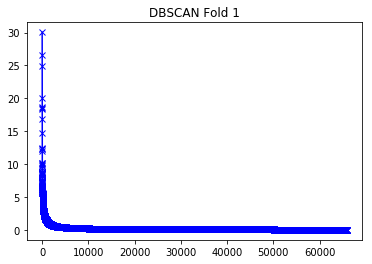

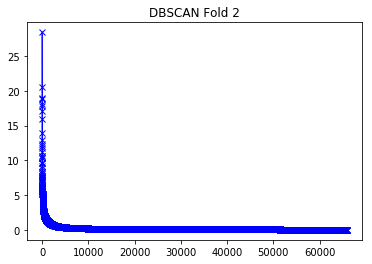

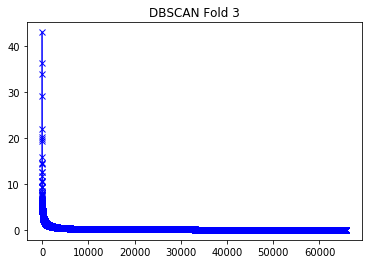

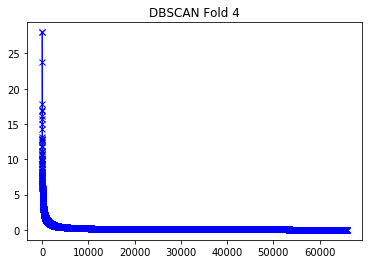

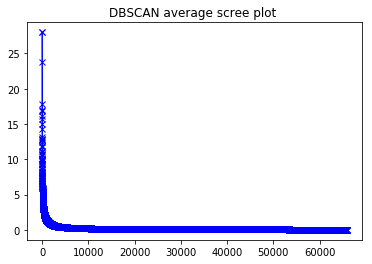

In [79]:
%%time
#Version 1 - Reading pkl files from step 0 and clustering it{
data_path = '../../data/pkl/'
classes = ['animate','inanimate']


result= {}

k = 4 #Total Number of folds
fold = 1
clf_result = {}
    
for i in range(k):

    print('Perfoming Fold: ', fold)
   
    
    if os.path.exists('../../data/pkl/kmeans_first_'+str(fold)+'.pickle'):
        with open('../../data/pkl/kmeans_first_'+str(fold)+'.pickle',"rb") as f:
            X_new,pred_kmeans,kmeans = pickle.load(f)
    else:   
        with open(data_path+classes[0]+'_fold_'+str(fold)+'_train.pkl') as f:
            X_fold = pickle.load(f)
        with open(data_path+classes[1]+'_fold_'+str(fold)+'_train.pkl') as f:
            y_fold = pickle.load(f)
        
        #65827
        X = np.column_stack((X_fold,y_fold))
        kmeans = MiniBatchKMeans(n_clusters=10, #Change This
                                 batch_size=6,
                                 max_iter=10).fit(X)
        #print kmeans.cluster_centers_
        pred_kmeans = kmeans.predict(X)
        X_new = kmeans.cluster_centers_

        with open('../../data/pkl/kmeans_first_'+str(fold)+'.pickle', 'wb') as handle:
            pickle.dump([X_new,pred_kmeans,kmeans], handle, protocol=pickle.HIGHEST_PROTOCOL)

    #DO CLUSTERING AND GET CLUSTERS
    from sklearn.neighbors import NearestNeighbors
        
    method ='DBSCAN'
    print(method)
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(X_new)
    distances, indices = nbrs.kneighbors(X_new)
    #print(distances,indices)
    distances = np.sort(distances, axis=0)[::-1]
    distances = distances[:,1]
    plt.figure(fold)
    plt.plot(distances,'bx-')
    plt.title(str(method)+' Fold '+ str(fold))
    
    for i in range(len(indices)):
        if clf_result.get(i,None) is None:
            clf_result[i] = 0.
        else:
            clf_result[i] += distances[i]
            
    with open('../../data/pkl/'+str(method)+'_scree_fold_'+str(fold)+'.pickle', 'wb') as handle:
        pickle.dump([distances, indices], handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    result[fold] = [distances, indices]
    fold += 1


for i in range(len(indices)):
    clf_result[i] =float(clf_result[i]) / 4.
dstances = clf_result.values()
dstances = np.sort(distances, axis=0)[::-1]

plt.figure(fold)
plt.plot(range(len(dstances)), dstances,'bx-')
plt.title(str(method)+' average scree plot ')

'''

print('y = [')
for i in range(len(dstances)):
    if i== len(dstances) -1:
        print dstances[i],']'
    else:
        print dstances[i],','

#Works Only with Python 3

import matplotlib
%matplotlib inline
from kneed import KneeLocator
y = [39.48572377,29.85299989 , 9.48860291 , 6.87495423 , 6.61210015 , 5.04854712 ,4.69691816,  3.80722248,  3.74839207 , 3.74839207]
kn = KneeLocator(range(len(y)), y, S=1.0, curve='convex', direction='decreasing')
print kn.knee

kn.plot_knee()
'''
#}

In [ ]:
result

In [ ]:
'''
#Version 2 - Reading pkl files from step 0 and clustering it{
data_path = '../../data/pkl/'
classes = ['animate','inanimate']


result= {}

k = 4 #Total Number of folds
fold = 1

for i in range(k):
    
    print('Perfoming Fold: ', fold)
    clf_result = {}
    
    with open(data_path+classes[0]+'_fold_'+str(fold)+'_train.pkl') as f:
        X_fold = pickle.load(f)
    with open(data_path+classes[1]+'_fold_'+str(fold)+'_train.pkl') as f:
        y_fold = pickle.load(f)
    
   
    
    X = np.column_stack((X_fold,y_fold))
    
    
    #DO CLUSTERING AND GET CLUSTERS
    
    from sklearn.cluster import KMeans
    
    for j in range(1,101,1):
        clf_result[j] = {}
        print j
        clf = KMeans(n_clusters=j, random_state=143)
        y_pred = clf.fit_predict(X)
        #print clf.cluster_centers_

        for label in set(clf.labels_):
            print('Cluster: ',j,'Label: ', label)
            
          
            #Lesioning and measuring performance
            pred = clf.predict(X)

            loc = np.where(pred==label)
            lambda_mask = np.ones(shape=((659272,)))
            lambda_mask[loc] = 0.

            #plt.scatter(X[:,0],X[:,1], c=y_pred) 

            sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
            model = AlexNet(weights_path="../../data/weights/alexnet_weights.h5",lambda_mask=lambda_mask)
            model.compile(optimizer=sgd, loss='mse')
            
            flag = 0
            dprime = 0.
            for p in classes:
                im_valid_test = []
                image_list_valid = '../../data/pkl/'+p+'_image_list_valid_fold_'+str(fold)+'.txt'
                with open(image_list_valid,'rb') as f:
                    for line in f.readlines():
                        im_valid_test.append(line.strip('\n'))
                im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(227,227), color_mode="rgb")
                out = model.predict(im_temp,batch_size=64)

                true_valid_wids = []
                for i in im_valid_test:
                        temp1 = i.split('/')[4]
                        temp = temp1.split('.')[0].split('_')[2]
                        true_valid_wids.append(truth[int(temp)][1])

                predicted_valid_wids = []
                for i in range(len(im_valid_test)):
                    #print im_list[i], pprint_output(out[i]), true_wids[i]
                    predicted_valid_wids.append(pprint_output(out[i]))

                count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

                print str(p)+' '+str(fold)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)
                
                if flag == 0:
                    with open('../../data/animate_no_lesion_performance.txt','r') as f:
                        tmp = f.readlines()[fold-1]
                        cnt = int(tmp.split(' ')[2])
                
                    dprime = float(count) / cnt
                    flag = 1
                elif flag == 1:
                    with open('../../data/inanimate_no_lesion_performance.txt','r') as f:
                        tmp = f.readlines()[fold-1]
                        cnt = int(tmp.split(' ')[2])
                    dprime -= float(count) / cnt
                    
            clf_result[j][label] = dprime
    
    result[fold] = clf_result
    fold += 1
#}
'''

In [11]:
#Loading the pickle files
method ='KMeans'

k = 4
result ={}
for i in range(1,k+1,1):
    name = '../../data/pkl/'+str(method)+'_50_scree_fold_'+str(i)+'.pickle'   #CHANGE
    with open(name,"rb") as f:
        result[i] = pickle.load(f)

In [77]:
#Loading the pickle files - Type 2
method ='DBSCAN'

k = 4
result ={}
for i in range(1,k+1,1):
    name = '../../data/pkl/'+str(method)+'_scree_fold_'+str(i)+'.pickle'   #CHANGE
    with open(name,"rb") as f:
        result[i] = pickle.load(f)

In [81]:
result

{1: {1: {0: 0.0},
  2: {0: 0.0, 1: 0.5384615384615384},
  3: {0: 0.0, 1: 0.07692307692307698, 2: 0.46153846153846145},
  4: {0: 0.0, 1: 0.0, 2: 0.07692307692307687, 3: 0.10256410256410253},
  5: {0: 0.0,
   1: 0.02564102564102555,
   2: -0.10256410256410253,
   3: 0.0,
   4: 0.02564102564102566},
  6: {0: 0.02564102564102566,
   1: -0.10256410256410253,
   2: 0.0,
   3: -0.1282051282051282,
   4: -0.10256410256410253,
   5: 0.0},
  7: {0: 0.0,
   1: -0.10256410256410253,
   2: -0.10256410256410253,
   3: -0.10256410256410264,
   4: -0.07692307692307698,
   5: 0.0,
   6: -0.10256410256410253},
  8: {0: 0.0,
   1: -0.1282051282051282,
   2: -0.1282051282051282,
   3: -0.10256410256410253,
   4: -0.10256410256410253,
   5: 0.0,
   6: -0.05128205128205132,
   7: -0.07692307692307687},
  9: {0: 0.02564102564102566,
   1: -0.10256410256410253,
   2: -0.1282051282051282,
   3: -0.1282051282051282,
   4: -0.1282051282051282,
   5: 0.0,
   6: -0.05128205128205132,
   7: -0.07692307692307687,
  

In [82]:
result[1]

{1: {0: 0.0},
 2: {0: 0.0, 1: 0.5384615384615384},
 3: {0: 0.0, 1: 0.07692307692307698, 2: 0.46153846153846145},
 4: {0: 0.0, 1: 0.0, 2: 0.07692307692307687, 3: 0.10256410256410253},
 5: {0: 0.0,
  1: 0.02564102564102555,
  2: -0.10256410256410253,
  3: 0.0,
  4: 0.02564102564102566},
 6: {0: 0.02564102564102566,
  1: -0.10256410256410253,
  2: 0.0,
  3: -0.1282051282051282,
  4: -0.10256410256410253,
  5: 0.0},
 7: {0: 0.0,
  1: -0.10256410256410253,
  2: -0.10256410256410253,
  3: -0.10256410256410264,
  4: -0.07692307692307698,
  5: 0.0,
  6: -0.10256410256410253},
 8: {0: 0.0,
  1: -0.1282051282051282,
  2: -0.1282051282051282,
  3: -0.10256410256410253,
  4: -0.10256410256410253,
  5: 0.0,
  6: -0.05128205128205132,
  7: -0.07692307692307687},
 9: {0: 0.02564102564102566,
  1: -0.10256410256410253,
  2: -0.1282051282051282,
  3: -0.1282051282051282,
  4: -0.1282051282051282,
  5: 0.0,
  6: -0.05128205128205132,
  7: -0.07692307692307687,
  8: -0.20512820512820507},
 10: {0: -0.717

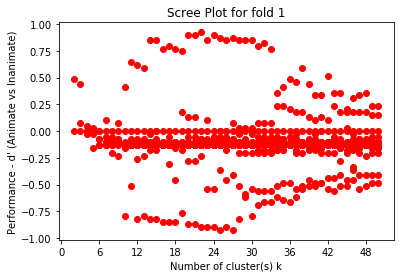

In [12]:
f = 1
clf_result = result[f]


fig = plt.figure(1)
#X = range(1,51,1)
X = range(2,51,1)
for cl in X:
    i = 0
    for item in clf_result[cl].keys():
        plt.plot(cl,clf_result[cl][item],'ro')
        i += 1
        
plt.xticks(X)
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Performance - d' (Animate vs Inanimate)")
plt.title('Scree Plot for fold '+ str(f))
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
plt.savefig('../../results/scree/'+str(method)+'_results_fold_'+str(f)+'.svg', format='svg', dpi=1200)

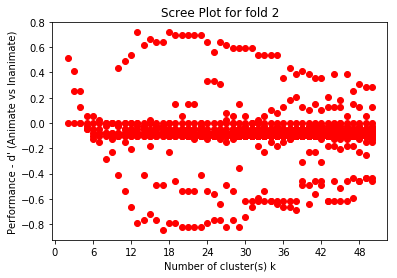

In [13]:
f = 2
clf_result = result[f]


plt.figure(1)
#X = range(1,51,1)
X = range(2,51,1)
for cl in X:
    i = 0
    for item in clf_result[cl].keys():
        plt.plot(cl,clf_result[cl][item],'ro')
        i += 1
        
plt.xticks(X)
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Performance - d' (Animate vs Inanimate)")
plt.title('Scree Plot for fold '+ str(f))
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
plt.savefig('../../results/scree/'+str(method)+'_results_fold_'+str(f)+'.svg', format='svg', dpi=1200)

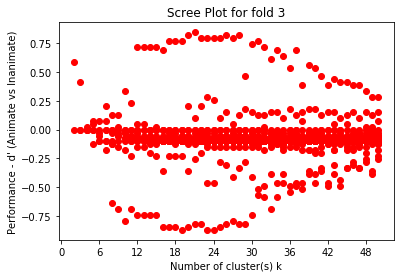

In [14]:
f = 3
clf_result = result[f]


plt.figure(1)
#X = range(1,51,1)
X = range(2,51,1)
for cl in X:
    i = 0
    for item in clf_result[cl].keys():
        plt.plot(cl,clf_result[cl][item],'ro')
        i += 1
        
plt.xticks(X)
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Performance - d' (Animate vs Inanimate)")
plt.title('Scree Plot for fold '+ str(f))
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
plt.savefig('../../results/scree/'+str(method)+'_results_fold_'+str(f)+'.svg', format='svg', dpi=1200)

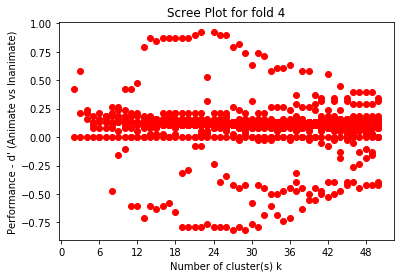

In [15]:
f = 4
clf_result = result[f]


plt.figure(1)
#X = range(1,51,1)
X = range(2,51,1)
for cl in X:
    i = 0
    for item in clf_result[cl].keys():
        plt.plot(cl,clf_result[cl][item],'ro')
        i += 1
        
plt.xticks(X)
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Performance - d' (Animate vs Inanimate)")
plt.title('Scree Plot for fold '+ str(f))
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
plt.savefig('../../results/scree/'+str(method)+'_results_fold_'+str(f)+'.svg', format='svg', dpi=1200)

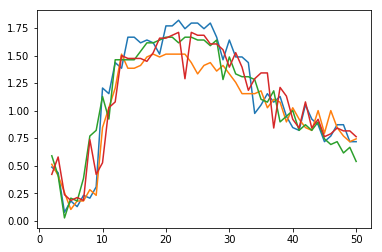

In [16]:
#Find MaxAd', MaxId' and its average
plt.figure()
noc = 4
for i in range(1,noc+1,1):
    X = []
    Y = []
    for j in range(2,51,1):
        X.append(j)
        temp = []
        for key, value in result[i][j].iteritems():
            temp.append(value)
        maxa = max(temp)
        maxi = min(temp)
        avg = float(maxa - maxi)
        Y.append(avg)
    #print X,Y
    plt.plot(X,Y)

1.03019568151 21


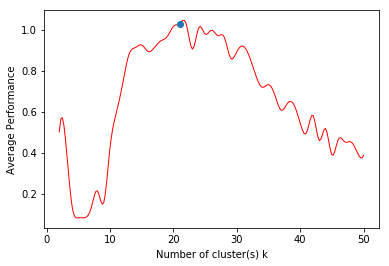

In [17]:
#Smooth average graph

noc = 4
flag = 0
X = range(2,51,1)
an_fold =[]
ian_fold = []
Y = []
for i in range(1,noc+1,1):
    if i == 2:
        flag = 1
    for j in range(2,51,1):
        temp = []
        for key, value in result[i][j].iteritems():
            temp.append(value)
        maxa = max(temp)
        maxi = min(temp)
        if flag == 0:
            an_fold.append(maxa)
            ian_fold.append(maxi)
        else:
            an_fold[j-2] += maxa
            ian_fold[j-2] = maxi

for j in range(2,51,1):
    maxa = (an_fold[j-2]) / 4.
    maxi = (ian_fold[j-2]) /4.
    diff = maxa - maxi
    Y.append(diff)
    
x_sm = np.array(X)
y_sm = np.array(Y)

x_smooth = np.linspace(x_sm.min(), x_sm.max(), 200)
y_smooth = spline(X, Y, x_smooth)

plt.plot(x_smooth, y_smooth, 'r', linewidth=1)
plt.plot(Y.index(max(Y))+1,max(Y),'o')
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Average Performance")
plt.savefig('../../results/scree/'+str(method)+'_results_fold_avg.svg', format='svg', dpi=1200)
print max(Y), Y.index(max(Y)) + 1